# Chapter 3: Risk

## The Important Lessons

- Risk defined as the standard deviation of return
- Risks are not additive
- Many institutional investors care more about active and residual risk rather than total risk
- Active risk primarily depends on size of active position not size of benchmark position
- Risk models identify the important sources of risk and its components

## Properties of Risk

### The Source of Risk

Risk comes from the probability distribution of returns. We can get a sense of the distribution via a histogram:

In [109]:
import numpy as np
import pandas as pd
# from pandas.io.data import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ccxt
%matplotlib inline 

In [110]:
binance = ccxt.binance()
coin1 = 'ETH/USDT'
ticker = binance.fetch_ticker(coin1)
time = '1d'
limit = 100
coin_ticker = binance.fetch_ohlcv(coin1, time, limit=limit)
df = pd.DataFrame(coin_ticker, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Date'] = pd.to_datetime(df['Date'], unit = 'ms' )

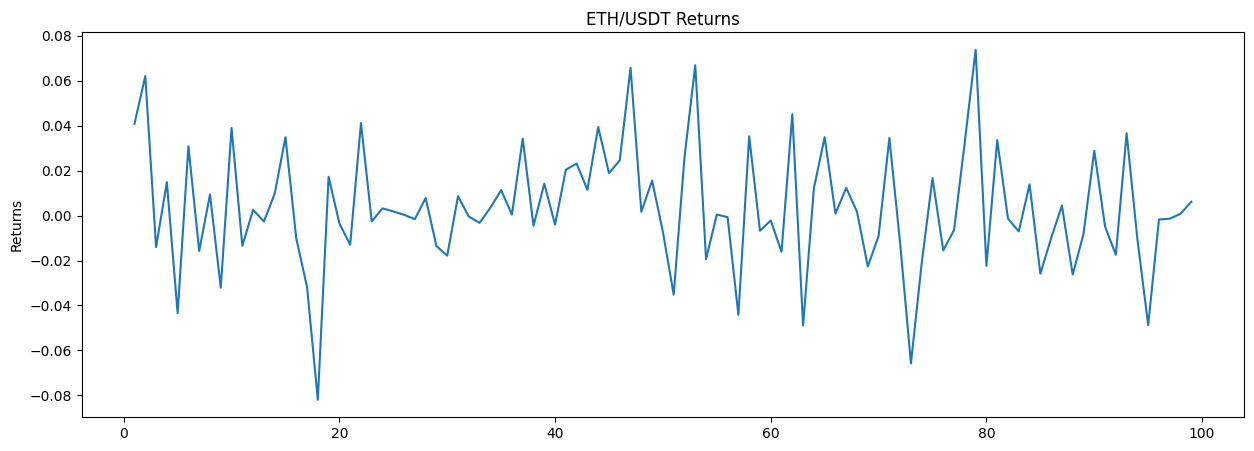

In [111]:
coin1_returns = pd.DataFrame(np.diff(np.log(df['Close'].values)))
coin1_returns.index = df.index.values[1:df.index.values.shape[0]]
coin1_returns.columns = [f'{coin1} Returns']

plt.figure(figsize=(15,5))
plt.plot(coin1_returns)
plt.ylabel('Returns')
plt.title(f'{coin1} Returns')
plt.show()

Text(0.5, 0, 'Daily Returns')

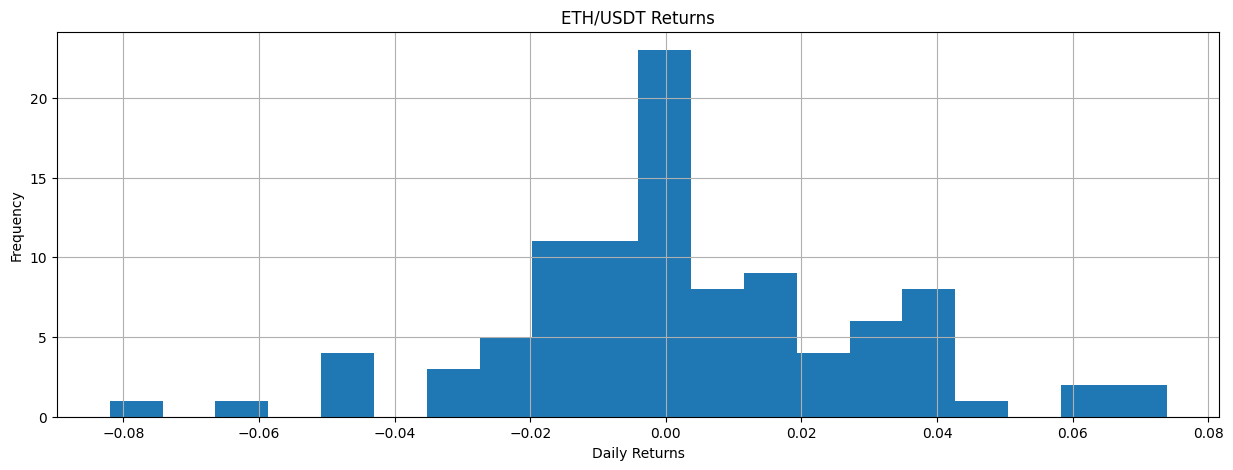

In [112]:
coin1_returns.hist(figsize=(15,5),bins=20,)
plt.ylabel("Frequency")
plt.xlabel("Daily Returns")

### Defining Risk

Rather than using the entire probability distribution to inform risk, the authors try to capture the essentials of risk. This creates some shortcomings. If we assume normally distributed returns, then all the risk measures are products of the mean and standard devation.

Standard deviation was Markowitz's definition of risk. Knowing just standard deviations and covariances, we can calculate portfolio standard deviations. 

### Limitations with Standard Deviation

One criticism is that standard deviation measures the possibility of returns above and below the mean. Most investors would define risk as small or negative returns. An alternative measure is **semivariance** or **downside risk**.

Semivariance is calculated similarly to varaince but only using returns belowthe mean. If the returns are symmetric then the semivaraince is exactly one-half of the variance. Downside risk has varying definitions but many just assume it is the square root of semivariance to give an analogy to standard deviation.

In [113]:
coin1_variance = (coin1_returns.var())
coin1_semivariance =(coin1_returns[coin1_returns<0].var())
print(coin1_variance)
print(coin1_semivariance)
print(coin1_semivariance/coin1_variance)

ETH/USDT Returns    0.000727
dtype: float64
ETH/USDT Returns    0.000316
dtype: float64
ETH/USDT Returns    0.434165
dtype: float64


For ETH returns, the semivariance is 43% of the variance. This is because the distribution is skewed to the left (negative returns) so the semivariance is more than half the variance.

A variant of semivariance is target semivariance which focuses on returns below a target.

There are some problems with downside risk : its definition is not as unambigious as standard deviation or variance nor are its statistical properties well known. It is also computationally challenging for large portfolio construction problems, and aggregating semivariance form assets to portfolios is extremely difficult to do effectively. In a larger sense, if returns are reasonably symmetric then most definitions of downside risk are simply proportional to standard deviation and contain no additional information. Active returns (relative to a benchmark) are symmetric by construction. Return asymmetries are also not stable over time and may be difficult to forecast - so past downside risk may not be a good predictor for future downside risk.

**Shortfall probability** is another risk definition. It is the probability that return will be below some target amount.

In [114]:
shortfall_prob = coin1_returns.values[coin1_returns.values<-0.01].shape[0] /coin1_returns.values.shape[0]
print("Probability of daily return below -1% is " + str(round(shortfall_prob*100,2)) + "%")

Probability of daily return below -1% is 28.28%


Forecasting can be particulary difficult for lower shortfall targets, as the shortfall can be influenced by just a few observations.

**Value at risk** is similar to shortfall probability, but it starts with a target probability (e.g. 5% lowest returns) and equates that to an associated return:

In [115]:
print(f"The worst 5% of {coin1} daily returns exceeded a " 
      + str(round(np.percentile(coin1_returns.values,5)*100,2)) 
      + "% return")

The worst 5% of ETH/USDT daily returns exceeded a -4.35% return


If we use a normal distribution then the distribution is completely defined by its mean and variance. But the evidence on financial time series suggests they are heavy-tailed, which is why many look beyond standard deviation as a measure of risk.

The authors focus on the normal distribution and standard deviation as a measure of risk for tractability.

### Standard Deviation Properties

- Does not have the portfolio property: the standard deviation of a portfolio is not the weighted average of the standard deviations of the constituents!

Let's load data for another stock:

In [116]:
coin2 = 'BIFI/USDT'       # coin to retreive data for
ticker = binance.fetch_ticker(coin2)
coin_ticker = binance.fetch_ohlcv(coin2, time, limit=limit)
df = pd.DataFrame(coin_ticker, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Date'] = pd.to_datetime(df['Date'], unit = 'ms' )

In [117]:
df.head(3)

,Date,Open,High,Low,Close,Volume
0,2022-11-28,354.5,355.6,340.0,342.7,869.688
1,2022-11-29,342.5,363.1,340.0,351.8,1953.775
2,2022-11-30,352.6,376.0,349.5,366.8,1902.530


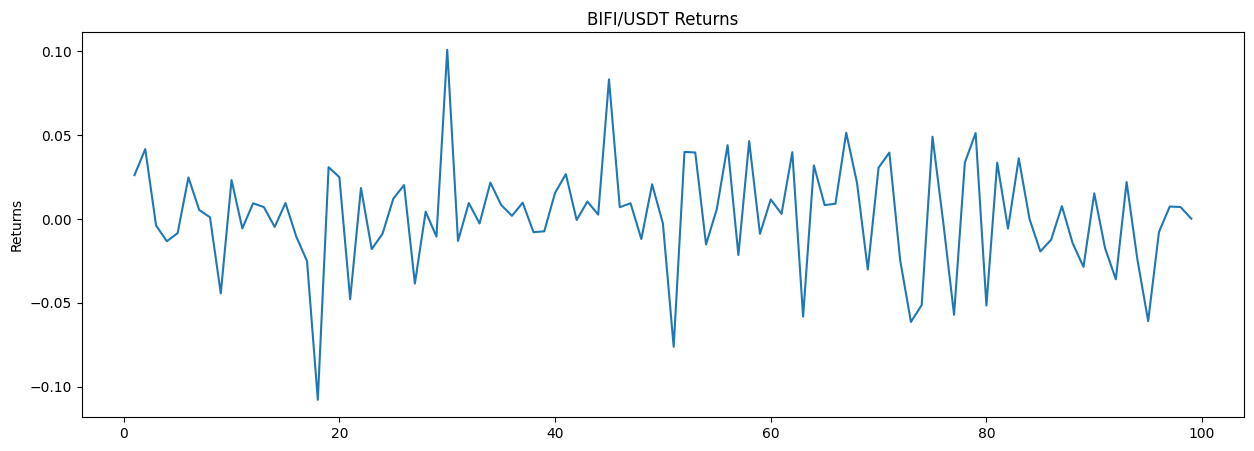

In [118]:
coin2_returns = pd.DataFrame(np.diff(np.log(df['Close'].values)))
coin2_returns.index = df.index.values[1:df.index.values.shape[0]]
coin2_returns.columns = [f'{coin2} Returns']

plt.figure(figsize=(15,5))
plt.plot(coin2_returns)
plt.ylabel('Returns')
plt.title(f'{coin2} Returns')
plt.show()

Now let us calculate the variance and the correlation between this stock and our previous stock:

In [119]:
coin2_std = (coin2_returns.std()).values[0]
coin1_std = (coin1_returns.std()).values[0]
returns = pd.concat([coin1_returns,coin2_returns],axis=1)
corr = returns.corr().iloc[0,1]

weighted_average = 0.5*coin2_std + 0.5*coin1_std

actual = np.sqrt(np.power(0.5*coin2_std,2) + np.power(0.5*coin1_std,2) + 2*(0.5*coin2_std)*(0.5*coin1_std)*corr)

print("Correlation is " + str(corr))
print("Weighted average std is " + str(weighted_average))
print("Actual std is " + str(actual))

Correlation is 0.6759382154746361
Weighted average std is 0.02957548197424479
Actual std is 0.02709393053061478


In [143]:
print(coin2_std)
print(coin1_std)

0.03218319722436756
0.026967766724122016


The two quantities above will only be equal if both stocks are perfectly correlated. Else, $\sigma_{p} \leq 0.5\sigma_{1} + 0.5\sigma_{2}$. This is the key to diversification: the risk of the whole can be less than the sum of its parts. We can visualize the effect of diversification for a two stock example as follows:

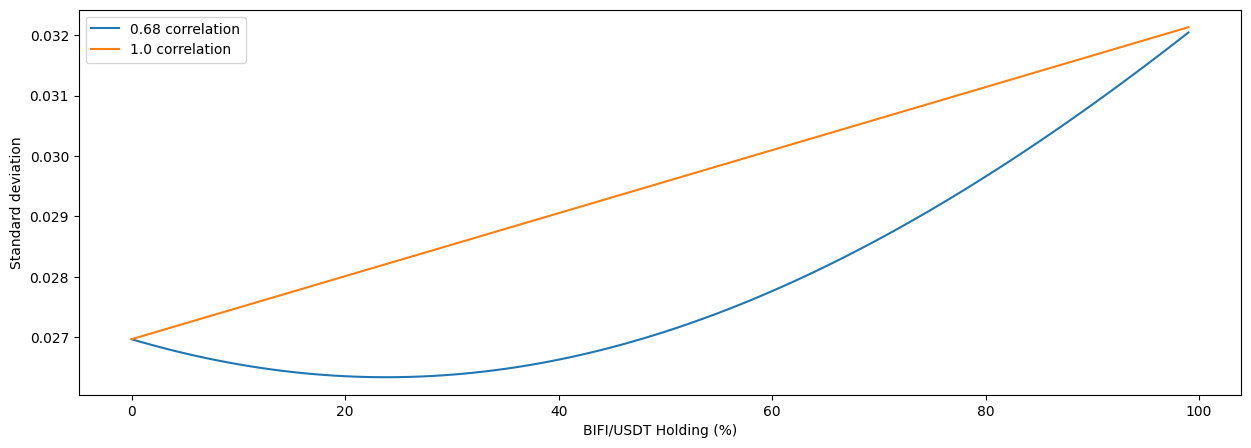

In [120]:
def portfolio_std(s1_std,s2_std,corr,s1_h=0.5):
    return np.sqrt(np.power(s1_h*coin2_std,2) + np.power((1-s1_h)*coin1_std,2) 
                   + 2*(s1_h*coin2_std)*((1-s1_h)*coin1_std)*corr)

portfolio_risk = [portfolio_std(coin2_std,coin2_std,corr,h/100) for h in range(0,100)]
perfect_corr_risk = [portfolio_std(coin2_std,coin2_std,1,h/100) for h in range(0,100)]

plt.figure(figsize=(15,5))
plt.plot(portfolio_risk,label=str(round(corr,2)) + " correlation")
plt.plot(perfect_corr_risk,label=str(1.00) + " correlation")
plt.xlabel(f"{coin2} Holding (%)")
plt.ylabel("Standard deviation")
plt.legend()
plt.show()

Suppose we have a portfolio of $N$ stocks each with risk $\sigma$ and uncorrelated returns. What would the risk of an equally weighted portfolio of these stocks be?

$$\sigma_{p} = \sqrt{  \sum_{i=1}^{N}(\frac{1}{N}\sigma)^{2} } = \sqrt{  N(\frac{1}{N}\sigma)^{2} } = \sqrt{  N} \frac{1}{N}\sigma = \frac{\sigma}{\sqrt{N}}$$

Unfortunately it is quite difficult to find uncorrelated stocks. Let's assume the correlation between the returns of all pairs of stocks is $\rho$. The variance of an equally weighted portfolio is:

$$\sigma_{p} = \sqrt{  \sum_{i=1}^{N}(\frac{1}{N}\sigma)^{2} + \frac{N(N-1)}{2}2\frac{1}{N^{2}}\sigma^{2}\rho}$$

$$\sigma_{p} = \sqrt{    \frac{1}{N}\sigma^{2}  + \frac{N(N-1)}{2}2\frac{1}{N^{2}}\sigma^{2}\rho}$$

$$\sigma_{p} = \sigma\sqrt{    \frac{1}{N}  + \frac{N(N-1)}{2}2\frac{1}{N^{2}}\rho}$$

$$\sigma_{p} = \sigma\sqrt{    \frac{1}{N}  + \frac{N(N-1)}{2}2\frac{1}{N^{2}}\rho}$$
$$\sigma_{p} = \sigma\sqrt{ \frac{1 + \rho(N-1)}{N}}$$

As $N \to \infty$, $\sigma_{p} \to \sigma\sqrt\rho$. Let's get a feel for this by loading a large set of stocks:

In [121]:
coin_list = ['BNB/USDT','XRP/USDT', "AGIX/USDT", "MDT/USDT",
        'ADA/USDT','MATIC/USDT','DOGE/USDT','SOL/USDT','DOT/USDT','SHIB/USDT']


In [122]:
def preprocess_df(coin):
    coin_ticker = binance.fetch_ohlcv(coin, time, limit=limit)
    df = pd.DataFrame(coin_ticker, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume']) 
    df['Date'] = pd.to_datetime(df['Date'], unit = 'ms' ) 
    return df

In [123]:
dfs = []
for coin in coin_list:
    dfs.append(preprocess_df(coin))
stocks = pd.concat(dfs,axis = 1)
stocks.head(2)

,Date,Open,High,Low,Close,Volume,Date,Open,High,Low,...,High,Low,Close,Volume,Date,Open,High,Low,Close,Volume
0,2022-11-28,307.7,309.6,286.6,293.5,603763.830,2022-11-28,0.3961,0.3991,0.3730,...,5.32,5.06,5.13,5094640.21,2022-11-28,0.000009,0.000009,0.000009,0.000009,3.912068e+12
1,2022-11-29,293.5,305.3,289.0,295.4,422502.385,2022-11-29,0.3888,0.4039,0.3829,...,5.35,5.09,5.30,3879496.66,2022-11-29,0.000009,0.000009,0.000009,0.000009,2.847885e+12


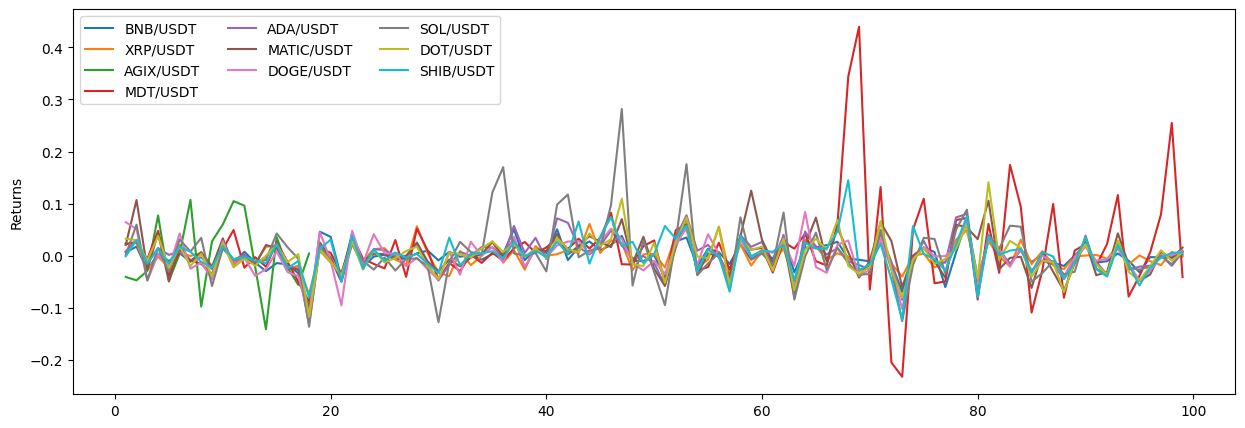

In [124]:
return_df = pd.DataFrame(np.diff(np.log(stocks['Close']).T).T)
return_df.index = stocks['Close'].index[1:]
return_df.columns = coin_list
plt.figure(figsize=(15,5))
x = plt.plot(return_df)
plt.ylabel('Returns')
plt.legend(iter(x), return_df.columns, ncol=3)
plt.show()

In [125]:
return_df.head()

,BNB/USDT,XRP/USDT,AGIX/USDT,MDT/USDT,ADA/USDT,MATIC/USDT,DOGE/USDT,SOL/USDT,DOT/USDT,SHIB/USDT
1,0.006453,0.023638,-0.040836,0.022185,0.008444,0.020607,0.064420,0.001500,0.032601,-0.001102
2,0.017450,0.024074,-0.047289,0.026235,0.030262,0.106910,0.051012,0.059654,0.029742,0.030404
3,-0.028000,-0.027092,-0.029043,-0.006598,-0.013266,-0.026170,-0.048158,-0.046991,-0.009200,-0.015086
4,0.003756,-0.002018,0.077214,0.047667,0.014520,0.042963,0.003434,0.014695,0.038083,0.012945
5,-0.010278,-0.022467,-0.048221,-0.038196,0.001566,-0.049586,-0.023787,-0.031114,-0.023403,-0.015119


We can obtain the historical covariance-variance matrix as follows:

In [126]:
cov = return_df.cov()
cov

,BNB/USDT,XRP/USDT,AGIX/USDT,MDT/USDT,ADA/USDT,MATIC/USDT,DOGE/USDT,SOL/USDT,DOT/USDT,SHIB/USDT
BNB/USDT,0.000658,0.000419,0.000260,0.000689,0.000686,0.000659,0.000676,0.000939,0.000690,0.000590
XRP/USDT,0.000419,0.000587,-0.000109,0.000562,0.000610,0.000606,0.000579,0.000853,0.000654,0.000452
AGIX/USDT,0.000260,-0.000109,0.004936,0.000804,0.000077,-0.000136,0.000117,-0.000028,-0.000147,0.000359
MDT/USDT,0.000689,0.000562,0.000804,0.007003,0.000916,0.000767,0.001031,0.001243,0.000970,0.001538
ADA/USDT,0.000686,0.000610,0.000077,0.000916,0.001128,0.000935,0.000924,0.001405,0.000963,0.000781
MATIC/USDT,0.000659,0.000606,-0.000136,0.000767,0.000935,0.001511,0.000869,0.001407,0.001122,0.000735
DOGE/USDT,0.000676,0.000579,0.000117,0.001031,0.000924,0.000869,0.001181,0.001196,0.000893,0.000884
SOL/USDT,0.000939,0.000853,-0.000028,0.001243,0.001405,0.001407,0.001196,0.003533,0.001601,0.001016
DOT/USDT,0.000690,0.000654,-0.000147,0.000970,0.000963,0.001122,0.000893,0.001601,0.001341,0.000790
SHIB/USDT,0.000590,0.000452,0.000359,0.001538,0.000781,0.000735,0.000884,0.001016,0.000790,0.001264


The variance of a portfolio is calculated as $h^{T}Vh$ where $h$ is a $(K,1)$ vector of portfolio weights. We will assume an equally-weighted portfolio:

In [127]:
h = np.ones(len(coin_list))*(1/len(coin_list))
p_std = np.sqrt(np.dot(np.dot(np.transpose(h),cov),h))
equal_std = np.dot(h,np.sqrt(np.diag(cov)))
print("Portfolio standard deviation is " + str(p_std))
print("Equally weighted standard deviation is " + str(equal_std))
print(f"Differnce is {abs((equal_std-p_std)/equal_std*100):.2f}%")

Portfolio standard deviation is 0.029806111868678813
Equally weighted standard deviation is 0.04422476965842993
Differnce is 32.60%


Our equation implies an average correlation between these stocks of around:

In [128]:
print(np.power(p_std/equal_std,2))

0.4542338498542931


While standard deviations (defined here as risk) don't add across stocks or time, variance will add across time if returns are uncorrelated from one interval to a next. This would mean variances would grow with the length of the forecast horizon and standard deviations will grow with the square root of the forecast horizon. So a 5% annual active risk is equivalent to a 2.5% active risk over the first quarter or a 10% active risk over four years. The variance (6.25, 25, 100) remains proportional to the length of the horizon.

To annualize risk we calculate: 

$\sigma_{annual} = \sqrt{12}\sigma_{monthly}$

## Relative and Active Risk

### Active Risk

In practice a manager might be judged on their return and risk *relative* to a benchmark. We define:

- Active return $r_{PA} = r_{P} - r_{B}$
- Active risk $\psi_{P} = Std\left(r_{PA}\right) = Std\left(r_{P}-r_{B}\right)$

Where $r_{P}$ is the return of the manager and $r_{B}$ is the return of the benchmark. The active risk is sometimes known as the tracking error of the portfolio as it describes how well the portfolio can track the benchmark.

To see an example, go back to our dual JPM/GS example and assume our benchmark is 60 percent BIFI and 40 percent ETH

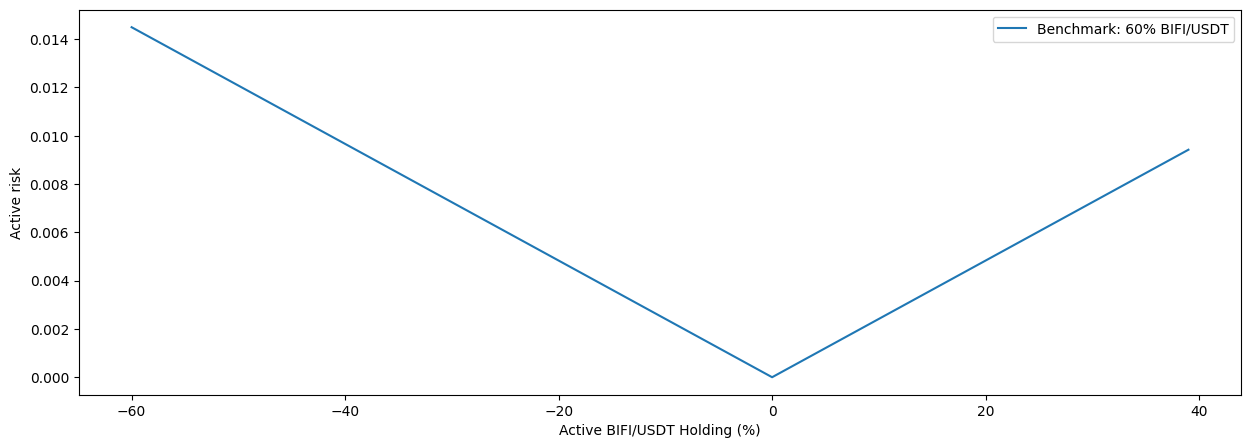

In [129]:
benchmark_weight = 0.6
portfolio_risk = portfolio_std(coin2_std,coin1_std,corr,benchmark_weight)
benchmark_returns = benchmark_weight*coin2_returns.values + (1-benchmark_weight)*coin1_returns.values
active_risks = [(((h/100)*coin2_returns.values+(1-(h/100))*coin1_returns.values) - benchmark_returns).std() 
                 for h in range(0,100)]

plt.figure(figsize=(15,5))
plt.plot(range(-60,40),active_risks,label=f"Benchmark: 60% {coin2}")
plt.xlabel(f"Active {coin2} Holding (%)")
plt.ylabel("Active risk")
plt.legend()
plt.show()

### Residual Risk

Residual risk is the risk of return orthogonal to the systematic return. The residual risk of portfolio $P$ relative to portfolio $B$ is denoted by $\omega_{P}$ and defined by:

$$\omega_{P} = \sqrt{\sigma_{P}^{2} - \beta_{P}^{2}\sigma_{B}^{2}}$$

This comes from the model $r_{P} = \beta_{P}r_{B} + \theta_{B}$ and the lack of correlation between the residual and market returns. Let's calculate the $\beta$ s for the return data we have. We first need to convert to excess returns by subtracting the risk-free rate and we need to load the benchmark (BTC):

In [130]:
# one_mon = DataReader('DGS1MO', 'fred',datetime(2006,1,1), datetime(2015,1,1))
coin3 = 'QNT/USDT'
one_day = preprocess_df(coin3)
one_day = pd.DataFrame(1 + np.log((one_day['Close'].values)))
one_day.index = one_day.index.values[:one_day.index.values.shape[0]]
one_day.columns = [coin3]
one_day.head()


,QNT/USDT
0,5.722064
1,5.732684
2,5.819475
3,5.799914
4,5.872139


In [131]:
benchmark_coin = 'BTC/USDT'
benchmark = preprocess_df(benchmark_coin)
benchmark_returns = pd.DataFrame(np.diff(np.log((benchmark['Close'].values))))
benchmark_returns.index = benchmark_returns.index.values[:benchmark_returns.index.values.shape[0]]
benchmark_returns.columns = [benchmark_coin]
benchmark_returns.head()

,BTC/USDT
0,0.014063
1,0.042922
2,-0.010912
3,0.006773
4,-0.012216


In [132]:
excess_returns = pd.concat([one_day, return_df, benchmark_returns], axis=1).dropna()
excess_returns = excess_returns.subtract(excess_returns[coin3].values, axis=0)

excess_returns.head()

,QNT/USDT,BNB/USDT,XRP/USDT,AGIX/USDT,MDT/USDT,ADA/USDT,MATIC/USDT,DOGE/USDT,SOL/USDT,DOT/USDT,SHIB/USDT,BTC/USDT
1,0.0,-5.726231,-5.709045,-5.773520,-5.710498,-5.724239,-5.712077,-5.668263,-5.731183,-5.700082,-5.733785,-5.689762
2,0.0,-5.802025,-5.795401,-5.866764,-5.793240,-5.789213,-5.712565,-5.768462,-5.759821,-5.789733,-5.789071,-5.830387
3,0.0,-5.827914,-5.827007,-5.828957,-5.806512,-5.813180,-5.826084,-5.848072,-5.846905,-5.809114,-5.815001,-5.793142
4,0.0,-5.868383,-5.874157,-5.794926,-5.824473,-5.857619,-5.829176,-5.868705,-5.857444,-5.834057,-5.859194,-5.884356
5,0.0,-5.850520,-5.862709,-5.888463,-5.878438,-5.838677,-5.889829,-5.864029,-5.871356,-5.863646,-5.855361,-5.827268


Next we calculate the betas:

In [134]:
import statsmodels.api as sm

def get_beta(stock,market):
    exog = sm.add_constant(market, prepend=True)
    mod = sm.OLS(stock, exog)
    return mod.fit().params[1] 

def get_residual_risk(benchmark_std,stock_beta,stock_std):
    return np.sqrt(np.power(stock_std,2) - np.power(stock_beta*benchmark_std,2))

def get_risk_measures(excess_returns):
    tickers,betas,total_risk,residual_risk = ([] for i in range(4))
    tickers = []
    for stock in excess_returns.columns:
        market_risk = excess_returns[f'{benchmark_coin}'].std()
        if stock not in [f'{coin3}',f'{benchmark_coin}']:
            beta = get_beta(excess_returns[stock],excess_returns[f'{benchmark_coin}'])
            stock_risk = excess_returns[stock].std()
            total_risk.append(stock_risk)
            residual_risk.append(get_residual_risk(market_risk,beta,stock_risk))
            betas.append(beta)
            tickers.append(stock)
    results = pd.DataFrame(np.array([betas,total_risk,residual_risk]).T)
    results.index = tickers
    results.columns = ['Betas','Total Risk','Residual Risk']
    return results

risk_summary = get_risk_measures(excess_returns)
risk_summary

,Betas,Total Risk,Residual Risk
BNB/USDT,0.467626,0.034973,0.025128
XRP/USDT,0.624992,0.039828,0.023007
AGIX/USDT,0.478513,0.074210,0.069911
MDT/USDT,0.474926,0.038597,0.029655
ADA/USDT,0.401868,0.033615,0.026325
MATIC/USDT,0.425309,0.044607,0.038735
DOGE/USDT,0.505230,0.046264,0.038074
SOL/USDT,0.214441,0.037739,0.036053
DOT/USDT,0.409236,0.037486,0.030855
SHIB/USDT,0.474946,0.032066,0.020441


Variance in the book measures the cost of risk. The cost of risk equates risk to an equivalent loss in expected return. The book associates the cost of risk with active or residual return. An example for a risk aversion coefficient of 0.1 is shown below:

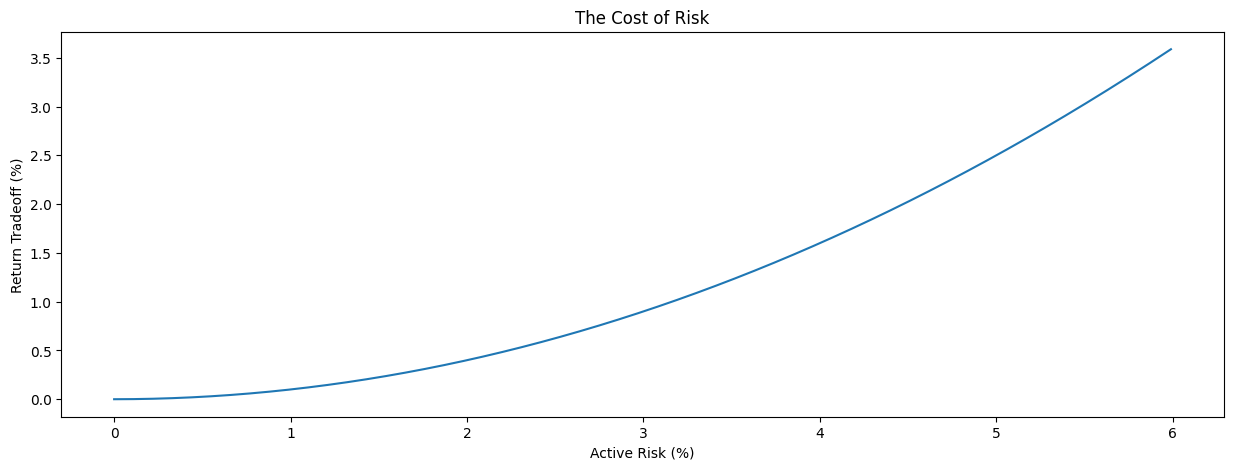

In [135]:
risk_aversion = 0.1
active_risk = np.array([i/100 for i in range(0,600)])
return_tradeoff = risk_aversion*np.power(active_risk,2)
plt.figure(figsize=(15,5));
plt.plot(active_risk,return_tradeoff);
plt.title("The Cost of Risk");
plt.xlabel("Active Risk (%)");
plt.ylabel("Return Tradeoff (%)");

So a 4% active risk produces a 1.6% loss in expected return (given this investor's preferences over risk).

## Elementary Risk Models

There is a significant problem in calculating portfolio risk. As we increase the size of the portfolio, we the number of covariance estimates we require increases exponentially; specifically, we need $N(N-1)/2$ correlations. The 10 stocks on the Binance are highlighted (45 covariances are needed).

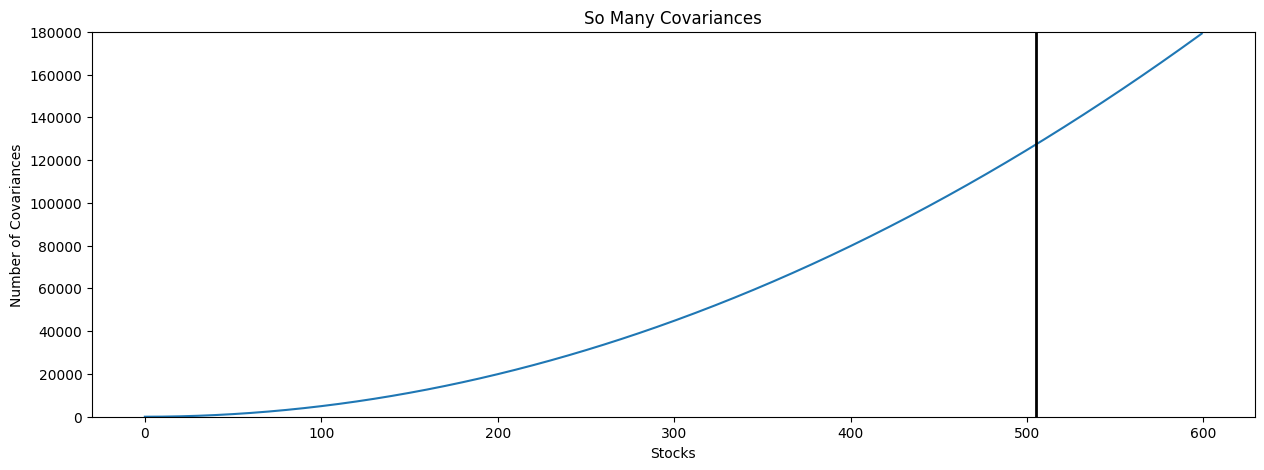

In [136]:
stock_no = np.array([i for i in range(0,600)])
correlations = np.array([i*(i-1)/2 for i in range(0,600)])
plt.figure(figsize=(15,5));
plt.plot(stock_no,correlations);
plt.title("So Many Covariances");
plt.xlabel("Stocks");
plt.ylabel("Number of Covariances");
plt.plot([505, 505], [0, 500000], 'k-', lw=2);
plt.ylim(0,180000);

It is a challenge to estimate so many quantities accurately - since we will perform portfolio optimization, even if only a small percentage of the estimates are wrong, they will severely impact the choice.

** The goal of a risk model is to accurately and efficiently forecast the covariance matrix**

There are three elementary stock risk models:
- The single-factor diagonal model
- The commmon correlation model
- The historical returns model

### The Single-Factor Diagonal Model

The single-factor model of risk was a precursor to CAPM but both models are distinct. It analyses returns as:

$$ r_{n} = \beta_{n}r_{M} + \theta_{n}  $$

Where $\beta_{n}$ is stock *n*'s beta and $\theta_{n}$ is the residual return. The single-factor risk model assumes that the residual returns $\theta_{n}$  are uncorrelated and therefore:

$$ Cov(r_{n},r_{m}) = \beta_{n}\beta_{m}\sigma^{2}_{M} $$
$$ \sigma^{2}_{n} = \beta^{2}_{n}\sigma^{2}_{M} + \omega^{2}_{n}$$

Let's calculate the covariance matrix for the stocks we had earlier:

In [137]:
betas = risk_summary['Betas'].values
market_risk = excess_returns[f'{benchmark_coin}'].std()
residual_risks = risk_summary['Residual Risk'].values

def single_factor_covariance(betas,market_risk,residual_risks,tickers=None):
    beta_vector = np.array([betas])
    cov_matrix = np.dot(beta_vector.T,beta_vector)
    cov_matrix = cov_matrix*np.power(market_risk,2)
    cov_matrix[np.diag_indices_from(cov_matrix)] = np.diag(cov_matrix)+np.power(residual_risks,2)
    results = pd.DataFrame(cov_matrix)
    
    if tickers is not None:
        results.index = tickers
        results.columns = tickers
        
    return results

sf_covmatrix = single_factor_covariance(betas,market_risk,residual_risks,risk_summary.index)
sf_covmatrix

,BNB/USDT,XRP/USDT,AGIX/USDT,MDT/USDT,ADA/USDT,MATIC/USDT,DOGE/USDT,SOL/USDT,DOT/USDT,SHIB/USDT
BNB/USDT,0.001223,0.000791,0.000605,0.000601,0.000508,0.000538,0.000639,0.000271,0.000518,0.000601
XRP/USDT,0.000791,0.001586,0.000809,0.000803,0.000680,0.000719,0.000854,0.000363,0.000692,0.000803
AGIX/USDT,0.000605,0.000809,0.005507,0.000615,0.000520,0.000551,0.000654,0.000278,0.000530,0.000615
MDT/USDT,0.000601,0.000803,0.000615,0.001490,0.000516,0.000547,0.000649,0.000276,0.000526,0.000610
ADA/USDT,0.000508,0.000680,0.000520,0.000516,0.001130,0.000462,0.000549,0.000233,0.000445,0.000516
MATIC/USDT,0.000538,0.000719,0.000551,0.000547,0.000462,0.001990,0.000581,0.000247,0.000471,0.000547
DOGE/USDT,0.000639,0.000854,0.000654,0.000649,0.000549,0.000581,0.002140,0.000293,0.000559,0.000649
SOL/USDT,0.000271,0.000363,0.000278,0.000276,0.000233,0.000247,0.000293,0.001424,0.000237,0.000276
DOT/USDT,0.000518,0.000692,0.000530,0.000526,0.000445,0.000471,0.000559,0.000237,0.001405,0.000526
SHIB/USDT,0.000601,0.000803,0.000615,0.000610,0.000516,0.000547,0.000649,0.000276,0.000526,0.001028


The problem with this model is that residual returns *are* correlated. The market-weighted average of residual returns is exactly zero:

$$ \sum_{n}h_{M}(n)\theta_{n} = 0 $$

As a result the residual correlation between stocks must be in general negative. To se this assume there are two stocks with equal market capitalization. The equation above implies $\theta_{2} = -\theta_{1}$ so there is 100% negative correlation. As the number of stocks $n$ increases the average negative correlation decreases towards 0. In practice, we should expect positive residual correlation among stocks in the same industry. The reasons why this simple model may still be attractive:

- It isolates market and residual risk
- It gives a conservative estimate of the residual covariance between stocks (0)

### The Common Correlation Model

This model requires an estimate of each stock's risk $\sigma_{n}$ and an average stock correlation $\rho$. This implies that the covariance between any 2 stocks is:

$$ Cov(r_{n},r_{m}) = \sigma_{m}\sigma_{n}\rho $$

Let's just use the risk estimates from the historical covariance matrix we estimated earlier along with the implied figure we had for average correlation:

In [138]:
residual_risks = risk_summary['Residual Risk'].values

def common_correlation_covariance(stock_risks,correlation,tickers=None):
    stock_risks = np.array([stock_risks])
    cov_matrix = np.dot(stock_risks.T,stock_risks)
    cov_matrix = cov_matrix*correlation
    cov_matrix[np.diag_indices_from(cov_matrix)] = np.diag(cov_matrix)/correlation
    results = pd.DataFrame(cov_matrix)
    
    if tickers is not None:
        results.index = tickers
        results.columns = tickers
            
    return results
    
cc_covmatrix = common_correlation_covariance(risk_summary['Total Risk'].values,0.511708472128,risk_summary.index)
cc_covmatrix

,BNB/USDT,XRP/USDT,AGIX/USDT,MDT/USDT,ADA/USDT,MATIC/USDT,DOGE/USDT,SOL/USDT,DOT/USDT,SHIB/USDT
BNB/USDT,0.001223,0.000713,0.001328,0.000691,0.000602,0.000798,0.000828,0.000675,0.000671,0.000574
XRP/USDT,0.000713,0.001586,0.001512,0.000787,0.000685,0.000909,0.000943,0.000769,0.000764,0.000653
AGIX/USDT,0.001328,0.001512,0.005507,0.001466,0.001276,0.001694,0.001757,0.001433,0.001423,0.001218
MDT/USDT,0.000691,0.000787,0.001466,0.001490,0.000664,0.000881,0.000914,0.000745,0.000740,0.000633
ADA/USDT,0.000602,0.000685,0.001276,0.000664,0.001130,0.000767,0.000796,0.000649,0.000645,0.000552
MATIC/USDT,0.000798,0.000909,0.001694,0.000881,0.000767,0.001990,0.001056,0.000861,0.000856,0.000732
DOGE/USDT,0.000828,0.000943,0.001757,0.000914,0.000796,0.001056,0.002140,0.000893,0.000887,0.000759
SOL/USDT,0.000675,0.000769,0.001433,0.000745,0.000649,0.000861,0.000893,0.001424,0.000724,0.000619
DOT/USDT,0.000671,0.000764,0.001423,0.000740,0.000645,0.000856,0.000887,0.000724,0.001405,0.000615
SHIB/USDT,0.000574,0.000653,0.001218,0.000633,0.000552,0.000732,0.000759,0.000619,0.000615,0.001028


This model is "quick and dirty" - it ignores linkages between stocks in similar industries and those with similar attributes.

### The Historical Covariance Model

This approach relies on historical variances and covariances. This approach is not robust for a large number of stocks. If the length of the time series $T\leq{N}$ we can find riskless positions. This is because a $N x N$ covariance matrix with $T$ periods of return has rank equal to $\min(N,T-1)$. (With $N$ stocks and $T$ periods we have $NT$ observations so we require, for a minimum of two observations per estimate, $T\geq(N+1)$). If we had monthly returns then we would require more than 40 years of data to construct a monthly historical covariance matrix. Even if these conditions are satisfied, the historical approach has problems:

- Historical risk cannot deal with the changing nature of a company due to mergers and spinoffs.
- Selection bias as takeovers, LBOs and failed companies are omitted.
- Sample bias can lead to gross misestimates of covariance. For a 500 asset covariance matrix, with 125,250 independent numbers, if 5% of these are wrong then there are 6,262 poor estimates.

We reproduce our historical matrix below:

In [139]:
cov

,BNB/USDT,XRP/USDT,AGIX/USDT,MDT/USDT,ADA/USDT,MATIC/USDT,DOGE/USDT,SOL/USDT,DOT/USDT,SHIB/USDT
BNB/USDT,0.000658,0.000419,0.000260,0.000689,0.000686,0.000659,0.000676,0.000939,0.000690,0.000590
XRP/USDT,0.000419,0.000587,-0.000109,0.000562,0.000610,0.000606,0.000579,0.000853,0.000654,0.000452
AGIX/USDT,0.000260,-0.000109,0.004936,0.000804,0.000077,-0.000136,0.000117,-0.000028,-0.000147,0.000359
MDT/USDT,0.000689,0.000562,0.000804,0.007003,0.000916,0.000767,0.001031,0.001243,0.000970,0.001538
ADA/USDT,0.000686,0.000610,0.000077,0.000916,0.001128,0.000935,0.000924,0.001405,0.000963,0.000781
MATIC/USDT,0.000659,0.000606,-0.000136,0.000767,0.000935,0.001511,0.000869,0.001407,0.001122,0.000735
DOGE/USDT,0.000676,0.000579,0.000117,0.001031,0.000924,0.000869,0.001181,0.001196,0.000893,0.000884
SOL/USDT,0.000939,0.000853,-0.000028,0.001243,0.001405,0.001407,0.001196,0.003533,0.001601,0.001016
DOT/USDT,0.000690,0.000654,-0.000147,0.000970,0.000963,0.001122,0.000893,0.001601,0.001341,0.000790
SHIB/USDT,0.000590,0.000452,0.000359,0.001538,0.000781,0.000735,0.000884,0.001016,0.000790,0.001264


### Which model performed better out-of-sample?

We can look at squared losses for each matrix out-of-sample:

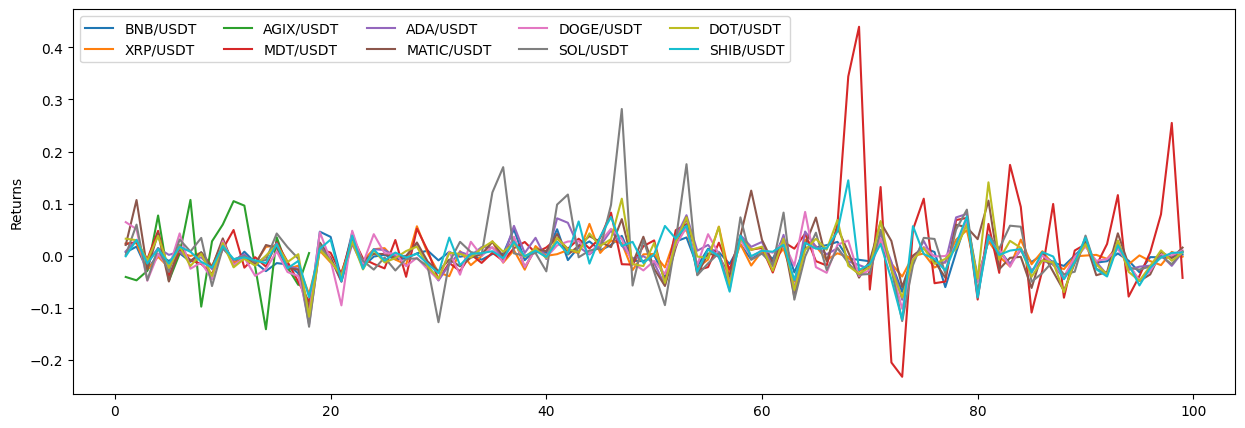

In [140]:
dfs = []
for coin in coin_list:
    dfs.append(preprocess_df(coin))
stocks_oos = pd.concat(dfs,axis = 1)
stocks_oos.head(2)

return_df_oos = pd.DataFrame(np.diff(np.log(stocks_oos['Close']).T).T)
return_df_oos.index = stocks_oos['Close'].index[1:]
return_df_oos.columns = coin_list

plt.figure(figsize=(15,5))
x = plt.plot(return_df_oos)
plt.ylabel('Returns')
plt.legend(iter(x), return_df_oos.columns, ncol=5)
plt.show()

In [141]:
realized_cov = return_df_oos.cov()
realized_cov

,BNB/USDT,XRP/USDT,AGIX/USDT,MDT/USDT,ADA/USDT,MATIC/USDT,DOGE/USDT,SOL/USDT,DOT/USDT,SHIB/USDT
BNB/USDT,0.000658,0.000419,0.000256,0.000689,0.000686,0.000659,0.000676,0.000939,0.000690,0.000590
XRP/USDT,0.000419,0.000587,-0.000111,0.000562,0.000610,0.000606,0.000579,0.000853,0.000654,0.000452
AGIX/USDT,0.000256,-0.000111,0.004936,0.000801,0.000072,-0.000140,0.000113,-0.000034,-0.000152,0.000356
MDT/USDT,0.000689,0.000562,0.000801,0.007004,0.000916,0.000767,0.001031,0.001242,0.000970,0.001538
ADA/USDT,0.000686,0.000610,0.000072,0.000916,0.001128,0.000935,0.000924,0.001405,0.000963,0.000781
MATIC/USDT,0.000659,0.000606,-0.000140,0.000767,0.000935,0.001511,0.000869,0.001407,0.001122,0.000735
DOGE/USDT,0.000676,0.000579,0.000113,0.001031,0.000924,0.000869,0.001181,0.001196,0.000893,0.000884
SOL/USDT,0.000939,0.000853,-0.000034,0.001242,0.001405,0.001407,0.001196,0.003533,0.001601,0.001017
DOT/USDT,0.000690,0.000654,-0.000152,0.000970,0.000963,0.001122,0.000893,0.001601,0.001341,0.000790
SHIB/USDT,0.000590,0.000452,0.000356,0.001538,0.000781,0.000735,0.000884,0.001017,0.000790,0.001264


In [142]:
equal_ensemble = (1/3)*cov + (1/3)*cc_covmatrix + (1/3)*sf_covmatrix

historical_loss = np.power(realized_cov-cov,2).sum().sum()
cc_loss = np.power(realized_cov-cc_covmatrix,2).sum().sum()
sf_loss = np.power(realized_cov-sf_covmatrix,2).sum().sum()
ens_loss = np.power(realized_cov-equal_ensemble,2).sum().sum()

loss_results = pd.DataFrame([historical_loss,cc_loss,sf_loss,ens_loss])
loss_results.index = ['Historical Covariance','Constant Correlation Covariance','Single Factor Covariance','Equal Ensemble Covariance']
loss_results.columns = ['Squared Loss']
loss_results

,Squared Loss
Historical Covariance,2.958533e-10
Constant Correlation Covariance,7.993307e-05
Single Factor Covariance,6.483174e-05
Equal Ensemble Covariance,2.990244e-05


The **Equal Ensemble Covariance** model had the best performance!